In [21]:
import pandas as pd
from razdel import sentenize, tokenize
from navec import Navec
from slovnet import Syntax, Morph
from ipymarkup import show_dep_ascii_markup as show_markup
from tqdm import tqdm
import re
from string import punctuation
import seaborn as sns
import compress_fasttext
from scipy.spatial.distance import cosine

In [2]:
df = pd.read_csv('data/processed.csv', index_col=0)

In [3]:
df

id  \
0       2c57d995-9894-11ed-99cc-05dc90903fb8   
1       2c5798c5-7203-11ed-8523-17f530626801   
2       2c578c42-53af-11ec-b40f-bf2cfe8c828d   
3       2c5749e5-2619-11ee-b379-0d972cff014f   
4       2c570865-3daa-11ee-833c-dd0276383d19   
...                                      ...   
726802  efc96525-d82b-11ed-861d-17f530626801   
726803  efc5a4e2-93d4-11ec-8f42-bf2cfe8c828d   
726804  efc574f5-4c94-11ee-ad80-dd0276383d19   
726805  efc4dca4-c1aa-11ec-9aad-bf2cfe8c828d   
726806  efc39f02-7549-11ec-b378-bf2cfe8c828d   

                                  additional_requirements         busy_type  \
0                                                     NaN  Полная занятость   
1       <p>- официальное трудоустройство</p> <p>- полн...  Полная занятость   
2                                         Ответственность  Полная занятость   
3                                                     NaN  Полная занятость   
4       <ul> <li>Период работ. Период работ: октябрь 2...          Сезонная   
...                                                   ...               ...   
726802                                                NaN  Полная занятость   
726803  Квотируемое рабочее место<br/>для н/с<br/>Отве...         Временная   
726804                                                NaN  Полная занятость   
726805                          Сохраненное рабочее место  Полная занятость   
726806                                                NaN  Полная занятость   

                     change_time  code_profession code_professional_sphere  \
0       2023-01-20T10:29:28+0300         226784.0                 Communal   
1       2023-10-19T09:50:03+0300         169696.0                 Industry   
2       2023-09-01T12:34:02+0300         240387.0                 Medicine   
3       2023-07-19T12:46:45+0300         117869.0                Education   
4       2023-08-18T12:32:39+0300         114428.0                Resources   
...                          ...              ...                      ...   
726802  2023-06-19T04:47:30+0300         167711.0             Agricultural   
726803  2023-03-23T08:55:55+0300         117869.0                 Industry   
726804  2023-09-06T12:08:25+0300         226322.0                Transport   
726805  2023-01-20T12:09:06+0300         114428.0                Transport   
726806  2023-09-20T11:48:24+0300         224469.0                 Industry   

                     date_create               date_modify  \
0       2023-01-20T10:29:28+0300  2023-10-25T13:47:08+0300   
1       2022-12-02T08:35:47+0300  2023-10-19T14:32:39+0300   
2       2022-03-10T01:56:54+0300  2023-09-01T12:43:50+0300   
3       2023-07-19T12:46:45+0300  2023-10-26T09:11:37+0300   
4       2023-08-18T12:32:39+0300  2023-08-18T15:09:05+0300   
...                          ...                       ...   
726802  2023-04-11T08:44:33+0300  2023-11-08T03:16:15+0300   
726803  2022-02-22T14:45:30+0300  2023-11-08T10:51:43+0300   
726804  2023-09-06T12:08:25+0300  2023-10-27T15:49:37+0300   
726805  2022-08-31T17:05:02+0300  2023-11-08T15:40:42+0300   
726806  2022-01-14T17:54:55+0300  2023-11-08T14:02:03+0300   

                       education original_source_type  ...    salary  \
0                         Высшее              COMPANY  ...  от 40000   
1       Среднее профессиональное              COMPANY  ...  от 45000   
2       Среднее профессиональное   EMPLOYMENT_SERVICE  ...  от 20000   
3                     Не указано              COMPANY  ...  от 16242   
4                     Не указано              COMPANY  ...  от 60000   
...                          ...                  ...  ...       ...   
726802                Не указано              COMPANY  ...  от 44500   
726803                   Среднее   EMPLOYMENT_SERVICE  ...  от 24750   
726804                    Высшее              COMPANY  ...  от 41000   
726805                   Среднее   EMPLOYMENT_SERVICE  ...  от 16242   
726806                    Высшее   EMPLOYM

## Syntax tree

In [4]:
navec = Navec.load('models/navec_news_v1_1B_250K_300d_100q.tar')
morph = Morph.load('models/slovnet_morph_news_v1.tar', batch_size=4)
syntax = Syntax.load('models/slovnet_syntax_news_v1.tar')
morph.navec(navec)
syntax.navec(navec);

In [5]:
text = 'Мы ждем от вас: Опыт на руководящей должности не менее 6 месяцев и Знание офисных программ – Word, Excel, умение пользоваться электронной почтой. Также вы должны уметь ездить на комбайне'

In [6]:
a = tokenize(text)

In [7]:
len([x for x in a])

34

In [8]:
next(a)

StopIteration: 

In [21]:
chunk = []

In [22]:
for sent in sentenize(text):
    tokens = [_.text for _ in tokenize(sent.text)]
    chunk.append(tokens)

In [23]:
chunk

[['Мы',
  'ждем',
  'от',
  'вас',
  ':',
  'Опыт',
  'на',
  'руководящей',
  'должности',
  'не',
  'менее',
  '6',
  'месяцев',
  'и',
  'Знание',
  'офисных',
  'программ',
  '–',
  'Word',
  ',',
  'Excel',
  ',',
  'умение',
  'пользоваться',
  'электронной',
  'почтой',
  '.'],
 ['Также', 'вы', 'должны', 'уметь', 'ездить', 'на', 'комбайне']]

In [9]:
a = morph.map(chunk)

In [10]:
morph_markup = next(a)

In [11]:
morph_markup

MorphMarkup(
    tokens=[MorphToken(
         text='Мы',
         pos='PRON',
         feats={'Case': 'Nom', 'Number': 'Plur', 'Person': '1'}
     ), MorphToken(
         text='ждем',
         pos='VERB',
         feats={'Aspect': 'Imp',
          'Mood': 'Ind',
          'Number': 'Plur',
          'Person': '1',
          'Tense': 'Pres',
          'VerbForm': 'Fin',
          'Voice': 'Act'}
     ), MorphToken(
         text='от',
         pos='ADP',
         feats={}
     ), MorphToken(
         text='вас',
         pos='PRON',
         feats={'Case': 'Gen', 'Number': 'Plur', 'Person': '2'}
     ), MorphToken(
         text=':',
         pos='PUNCT',
         feats={}
     ), MorphToken(
         text='Опыт',
         pos='NOUN',
         feats={'Animacy': 'Inan',
          'Case': 'Nom',
          'Gender': 'Masc',
          'Number': 'Sing'}
     ), MorphToken(
         text='на',
         pos='ADP',
         feats={}
     ), MorphToken(
         text='руководящей',
         pos=

In [12]:
markup = next(syntax.map(chunk))

In [13]:
words, deps = [], []
for token in markup.tokens:
    words.append(token.text)
    source = int(token.head_id) - 1
    target = int(token.id) - 1
    if source > 0 and source != target:  # skip root, loops
        deps.append([source, target, token.rel])

In [14]:
show_markup(words, deps)

            ┌► Мы           nsubj
          ┌─└─ ждем         
          │ ┌► от           case
┌───────┌─└►└─ вас          obl
│       │   ┌► :            punct
│   ┌─┌─└──►└─ Опыт         parataxis
│   │ │   ┌──► на           case
│   │ │   │ ┌► руководящей  amod
│   │ └──►└─└─ должности    nmod
│   │       ┌► не           advmod
│   │     ┌►└─ менее        advmod
│   │     │ ┌► 6            nummod
│ ┌►│     └─└─ месяцев      obl
│ │ │       ┌► и            cc
│ │ └────►┌─└─ Знание       conj
│ │       │ ┌► офисных      amod
│ │       └►└─ программ     nmod
│ │         ┌► –            punct
└►│     ┌─┌─└─ Word         parataxis
  │     │ │ ┌► ,            punct
  │     │ └►└─ Excel        conj
  │     │   ┌► ,            punct
  │     └►┌─└─ умение       conj
  └─────┌─└──► пользоваться nmod
        │   ┌► электронной  amod
        └──►└─ почтой       obj


In [15]:
def find_noun_phrases(syntax_markup, morph_markup):
    matching_nodes = []
    
    def explore_subtree(node):
        matching_descendants = []
        for child in syntax_markup.tokens:
            if (child.head_id == node.id) and (child.id != node.id) and (child not in matching_nodes):
                # print(child.text)
                matching_descendants.append(child)
                matching_descendants.extend(explore_subtree(child))
        return matching_descendants
    
    for syntax_token, morph_token in zip(syntax_markup.tokens, morph_markup.tokens):
        if (morph_token.pos == 'NOUN') and (syntax_token not in matching_nodes):
            matching_nodes.append(syntax_token)
            matching_nodes.extend(explore_subtree(syntax_token))
            
    matching_nodes = list(set(matching_nodes))
    matching_nodes = sorted(matching_nodes, key=lambda x: int(x.id))

    return matching_nodes

In [16]:
def get_noun_phrases(text: str):
    chunk = []
    for sent in sentenize(text):
        tokens = [_.text for _ in tokenize(sent.text)]
        chunk.append(tokens)
    
    # print(next(syntax.map(chunk)))
    text_noun_phrases = []
    for syntax_markup, morph_markup in zip(syntax.map(chunk), morph.map(chunk)):
        noun_phrases = find_noun_phrases(syntax_markup, morph_markup)
        text_noun_phrases.append(' '.join([x.text for x in noun_phrases]))
    
    return text_noun_phrases

In [17]:
get_noun_phrases('Мы требуем от вас опыт работы за столом. Кроме этого, вы должны уметь работать на бетономешалке, а также вы должны уметь работать на бетономешалке')

['опыт работы за столом', 'на бетономешалке на бетономешалке']

In [18]:
requirements_noun_phrases = []
html_tags_pattern = re.compile(r'<.*?>')    

for i in tqdm(df['position_requirements']):
    if isinstance(i, str):
        # print(i)
        cleaned_text = re.sub(html_tags_pattern, '', i)
        if (not cleaned_text.isspace()) and cleaned_text:
            requirements_noun_phrases.append(get_noun_phrases(cleaned_text))
            continue
    requirements_noun_phrases.append([])

100%|██████████| 726807/726807 [1:31:06<00:00, 132.96it/s] 


In [19]:
df['requirements_noun_phrases'] = requirements_noun_phrases

In [20]:
df

id  \
0       2c57d995-9894-11ed-99cc-05dc90903fb8   
1       2c5798c5-7203-11ed-8523-17f530626801   
2       2c578c42-53af-11ec-b40f-bf2cfe8c828d   
3       2c5749e5-2619-11ee-b379-0d972cff014f   
4       2c570865-3daa-11ee-833c-dd0276383d19   
...                                      ...   
726802  efc96525-d82b-11ed-861d-17f530626801   
726803  efc5a4e2-93d4-11ec-8f42-bf2cfe8c828d   
726804  efc574f5-4c94-11ee-ad80-dd0276383d19   
726805  efc4dca4-c1aa-11ec-9aad-bf2cfe8c828d   
726806  efc39f02-7549-11ec-b378-bf2cfe8c828d   

                                  additional_requirements         busy_type  \
0                                                     NaN  Полная занятость   
1       <p>- официальное трудоустройство</p> <p>- полн...  Полная занятость   
2                                         Ответственность  Полная занятость   
3                                                     NaN  Полная занятость   
4       <ul> <li>Период работ. Период работ: октябрь 2...          Сезонная   
...                                                   ...               ...   
726802                                                NaN  Полная занятость   
726803  Квотируемое рабочее место<br/>для н/с<br/>Отве...         Временная   
726804                                                NaN  Полная занятость   
726805                          Сохраненное рабочее место  Полная занятость   
726806                                                NaN  Полная занятость   

                     change_time  code_profession code_professional_sphere  \
0       2023-01-20T10:29:28+0300         226784.0                 Communal   
1       2023-10-19T09:50:03+0300         169696.0                 Industry   
2       2023-09-01T12:34:02+0300         240387.0                 Medicine   
3       2023-07-19T12:46:45+0300         117869.0                Education   
4       2023-08-18T12:32:39+0300         114428.0                Resources   
...                          ...              ...                      ...   
726802  2023-06-19T04:47:30+0300         167711.0             Agricultural   
726803  2023-03-23T08:55:55+0300         117869.0                 Industry   
726804  2023-09-06T12:08:25+0300         226322.0                Transport   
726805  2023-01-20T12:09:06+0300         114428.0                Transport   
726806  2023-09-20T11:48:24+0300         224469.0                 Industry   

                     date_create               date_modify  \
0       2023-01-20T10:29:28+0300  2023-10-25T13:47:08+0300   
1       2022-12-02T08:35:47+0300  2023-10-19T14:32:39+0300   
2       2022-03-10T01:56:54+0300  2023-09-01T12:43:50+0300   
3       2023-07-19T12:46:45+0300  2023-10-26T09:11:37+0300   
4       2023-08-18T12:32:39+0300  2023-08-18T15:09:05+0300   
...                          ...                       ...   
726802  2023-04-11T08:44:33+0300  2023-11-08T03:16:15+0300   
726803  2022-02-22T14:45:30+0300  2023-11-08T10:51:43+0300   
726804  2023-09-06T12:08:25+0300  2023-10-27T15:49:37+0300   
726805  2022-08-31T17:05:02+0300  2023-11-08T15:40:42+0300   
726806  2022-01-14T17:54:55+0300  2023-11-08T14:02:03+0300   

                       education original_source_type  ... salary_min  \
0                         Высшее              COMPANY  ...    40000.0   
1       Среднее профессиональное              COMPANY  ...    45000.0   
2       Среднее профессиональное   EMPLOYMENT_SERVICE  ...    20000.0   
3                     Не указано              COMPANY  ...    16242.0   
4                     Не указано              COMPANY  ...    60000.0   
...                          ...                  ...  ...        ...   
726802                Не указано              COMPANY  ...    44500.0   
726803                   Среднее   EMPLOYMENT_SERVICE  ...    24750.0   
726804                    Высшее              COMPANY  ...    41000.0   
726805                   Среднее   EMPLOYMENT_SERVICE  ...    16242.0   
726806                    Высше

In [22]:
df.to_csv('data/requirements_noun_phrases.csv', index=0)

### Analysis

In [17]:
np_df = pd.read_csv('data/requirements_noun_phrases.csv')
np_df['requirements_noun_phrases'] = np_df['requirements_noun_phrases'].apply(eval)

In [13]:
np_df['position_requirements']

0         <p>Высшее или срене-специальное образование в ...
1         <p>- образование не ниже среднего профессионал...
2         Добросовестное отношение к выполнению должност...
3                               <p>без вредных привычек</p>
4         <ul> <li>Удостоверение водителя, категория D;<...
                                ...                        
726802                   <p>согласно трудовому договору</p>
726803    Дополнительные пожелания у работодателя к канд...
726804                     <p>Знание программы ЕК АСУТР</p>
726805    НАЛИЧИЕ ВОДИТЕЛЬСКОГО УДОСТОВЕРЕНИЯ НА ПРАВО У...
726806    <ul> <li>Высшее профильное образование;</li> <...
Name: position_requirements, Length: 726807, dtype: object

In [19]:
cleaned_requirements = []
html_tags_pattern = re.compile(r'<.*?>')
for i in np_df['position_requirements']:
    if isinstance(i, str):
        cleaned_text = re.sub(html_tags_pattern, '', i)
        cleaned_requirements.append(cleaned_text)
    else:
        cleaned_requirements.append(i)
np_df['cleaned_requirements'] = cleaned_requirements

In [83]:
def count_tokens(text):
    if isinstance(text, str):
        return len([x for x in tokenize(text) if not x.text in punctuation])
    else:
        return 0

In [84]:
cleaned_requirements_len = []
for i in tqdm(np_df['cleaned_requirements']):
    cleaned_requirements_len.append(count_tokens(i))
cleaned_requirements_len = pd.Series(cleaned_requirements_len)

requirements_noun_phrases_len = []
for i in tqdm(np_df['requirements_noun_phrases']):
    requirements_noun_phrases_len.append(count_tokens(' '.join(i)))
requirements_noun_phrases_len = pd.Series(requirements_noun_phrases_len)

100%|██████████| 726807/726807 [00:57<00:00, 12634.72it/s]


In [96]:
np_len_delta = abs(cleaned_requirements_len - requirements_noun_phrases_len)

In [106]:
np_df['np_len_delta'] = np_len_delta

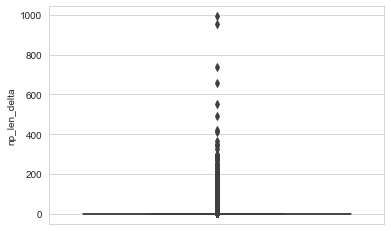

In [6]:
sns.boxplot(data=np_df, y='np_len_delta');

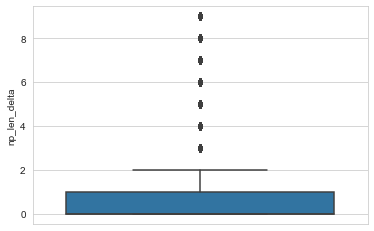

In [7]:
sns.boxplot(data=np_df[np_df['np_len_delta'] < 10], y='np_len_delta');

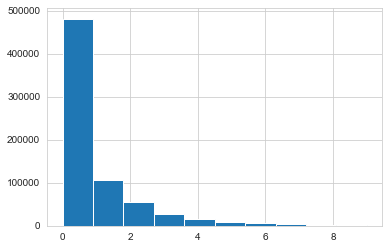

In [13]:
np_df[np_df['np_len_delta'] < 10]['np_len_delta'].hist();

In [28]:
sample = np_df[np_df['cleaned_requirements'].apply(lambda x: isinstance(x, str) and 'требуется' in x)].sample(25)
for i in sample.iterrows():
    print(i[1]['cleaned_requirements'])
    print('---- Noun phrases ----')
    print(' '.join(i[1]['requirements_noun_phrases']))
    print()

Опыт работы не требуется. Бесплатное обучение профессии на заводе,за время обучения начисляется заработная плата. Ответственность,стрессоустойчивость,желание обучаться и работать.
---- Noun phrases ----
Опыт работы Бесплатное обучение профессии на заводе за время обучения заработная плата Ответственность , стрессоустойчивость , желание обучаться и работать .

• образование среднее общее;• законченные курсы профессиональной подготовки, либо среднее профильное образование являются преимуществом;• опыт работы не требуется;• навыки планирования и прогнозирования;• готовность работать в условиях, требующих оперативного принятия решений и четкого соблюдения инструкций.
---- Noun phrases ----
образование ; • законченные курсы профессиональной подготовки , либо среднее профильное образование преимуществом ; • опыт работы • навыки планирования и прогнозирования ; • готовность работать в условиях , требующих оперативного принятия решений и четкого соблюдения инструкций

Наличие образования и опы

In [ ]:
np_df.to_csv('data/requirements_noun_phrases.csv', index=0)

## Word similarity

In [4]:
small_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load('models/geowac_tokens_sg_300_5_2020-100K-20K-100.bin')

In [7]:
cosine(small_model['попа и не попа'], small_model['попа'])

0.19744157791137695

In [19]:
html_tags_pattern = re.compile(r'<.*?>')
skills_tokens_similarity = []

for i in tqdm(range(len(df))):
    position_requirements = df['position_requirements'][i]
    vacancy_name = df['vacancy_name'][i]
    if isinstance(position_requirements, str) and isinstance(vacancy_name, str):
        cleaned_text = re.sub(html_tags_pattern, '', position_requirements)
        if (not cleaned_text.isspace()) and cleaned_text:
            vacancy_tokenized = [x.text for x in tokenize(vacancy_name.lower()) if x.text not in punctuation]
            vacancy_embedding = small_model.get_sentence_vector(vacancy_tokenized)
            
            skills_tokenized = [x.text for x in tokenize(cleaned_text.lower()) if x.text not in punctuation]
            tokens_similarity = []
            for token in skills_tokenized:
                token_embedding = small_model[token]
                similarity = 1 - cosine(vacancy_embedding, token_embedding)
                tokens_similarity.append((token, similarity))
            skills_tokens_similarity.append(tokens_similarity)
            continue
    skills_tokens_similarity.append([])

100%|██████████| 726807/726807 [22:29<00:00, 538.75it/s]


In [ ]:
skills_tokens_similarity

In [21]:
df['skills_similarity_fasttext'] = skills_tokens_similarity

In [22]:
df.to_csv('data/skills_similarity_fasttext.csv', index=0)

### Analysis

In [2]:
ft_df = pd.read_csv('data/only_skills_tokens.csv')
ft_df['skills_similarity_fasttext'] = ft_df['skills_similarity_fasttext'].apply(eval)

In [5]:
ft_df

vacancy_name  \
0                Инженер по подготовке производства   
1              Прессовщик на гидравлических прессах   
2                        Старшая медицинская сестра   
3                                           дворник   
4       Водитель автомобиля для перевозки персонала   
...                                             ...   
726802                               отловщик птицы   
726803                                      Дворник   
726804  инженер по организации и нормированию труда   
726805                          Водитель автомобиля   
726806         Инженер-технолог по металлообработке   

                               skills_similarity_fasttext  
0       [(высшее, 0.48074361718395275), (или, 0.330189...  
1       [(образование, 0.35513734755452875), (не, 0.34...  
2       [(добросовестное, 0.2681954722829205), (отноше...  
3       [(без, 0.15753729598253807), (вредных, 0.09903...  
4       [(удостоверение, 0.43990226378365826), (водите...  
...                                                   ...  
726802  [(согласно, 0.2437673933762574), (трудовому, 0...  
726803  [(дополнительные, 0.1286667552281182), (пожела...  
726804  [(знание, 0.4691414107309382), (программы, 0.5...  
726805  [(наличие, 0.25656713541620824), (водительског...  
726806  [(высшее, 0.4727725202394173), (профильное, 0....  

[726807 rows x 2 columns]

In [10]:
tokens_delta = []
for THRESHOLD in [0.2, 0.3, 0.4, 0.5, 0.6]:
    for i in ft_df['skills_similarity_fasttext']:
        delta = len(i) - len([x for x in i if x[1] > THRESHOLD])
        tokens_delta.append({'delta': delta, 'threshold': THRESHOLD})
tokens_delta_df = pd.DataFrame(tokens_delta)

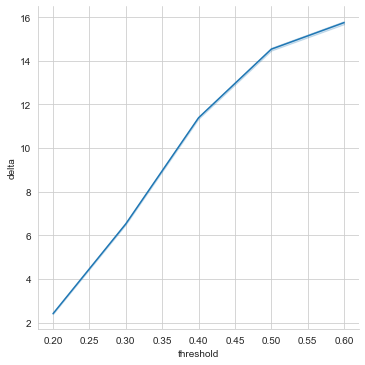

In [14]:
sns.relplot(x='threshold', y='delta', data=tokens_delta_df, kind='line')

In [18]:
for THRESHOLD in [0.2, 0.3, 0.4, 0.5, 0.6]:
    filtered_tokens = []
    for i in ft_df['skills_similarity_fasttext']:
        filtered_tokens.append(' '.join([x[0] for x in i if x[1] > THRESHOLD]))
    ft_df[f'similarity_{THRESHOLD}'] = filtered_tokens

In [27]:
for i in ft_df.sample(25).iterrows():
    print('==========Vacancy==========')
    print(i[1]['vacancy_name'])
    print('Original skills:')
    print(' '.join([x[0] for x in i[1]['skills_similarity_fasttext']]))
    for THRESHOLD in [0.2, 0.3, 0.4, 0.5, 0.6]:
        print(f'Similarity threshold {THRESHOLD}:')
        print(i[1][f'similarity_{THRESHOLD}'])
    print()

==========Vacancy==========
Слесарь по ремонту автомобилей
Original skills:
ответственность исполнительность дисциплинированность отсутствие вредных привычек
Similarity threshold 0.2:
ответственность исполнительность дисциплинированность отсутствие вредных привычек
Similarity threshold 0.3:
исполнительность
Similarity threshold 0.4:

Similarity threshold 0.5:

Similarity threshold 0.6:


==========Vacancy==========
Чистильщик металла, отливок, изделий и деталей
Original skills:
умение работать в коллективе здоровый активный образ жизни
Similarity threshold 0.2:
умение работать в коллективе здоровый активный образ жизни
Similarity threshold 0.3:
умение работать в здоровый образ жизни
Similarity threshold 0.4:

Similarity threshold 0.5:

Similarity threshold 0.6:


==========Vacancy==========
Врач-оториноларинголог
Original skills:
1 высшее профессиональное образование по одной из специальностей laquo лечебное дело raquo laquo педиатрия raquo и послевузовское профессиональное образование